## Синтаксический анализ

Для хранения результатов синтаксического анализа используется формат CONLLU. Это текстовый формат с табуляцией в качестве разделителя. Если строка начинается с #, то это комментарий, который может содержать ценную информацию. Далее идёт разобранное предложение, одна строка - одно слово.В троке хранятся:
- идентификатор;
- токен;
- лемма;
- часть речи;
- (в русском языке в основном не используется);
- грамматические параметры в формате параметр=значение;
- идентификатор родителя (0 означает, что данное слово является корнем дерева);
- роль слова при родителе (субъект, объект, прилагательное/существительное модификатор, ...;
- уточненная роль;
- дополнительные параметры.

In [1]:
!head -n 50 "/home/edward/projects/Alien_bases/Universal Dependencies/ud-treebanks-v2.8/UD_Russian-SynTagRus/ru_syntagrus-ud-train.conllu"

head: невозможно открыть '/home/edward/projects/Alien_bases/Universal Dependencies/ud-treebanks-v2.8/UD_Russian-SynTagRus/ru_syntagrus-ud-train.conllu' для чтения: Нет такого файла или каталога


## Синтаксический анализатор SpaCy

Одним из синтаксических анализаторов является Spacy. Библиотеки можно поставить при помощи pip, а как добавить **языковые модели** можно посмотреть [здесь](https://spacy.io/usage/models).

In [ ]:
!python -m spacy download ru_core_news_sm

In [3]:
# Импортируем нужные библиотеки.
import spacy
from spacy import displacy
from pprint import pprint
from collections import defaultdict
from tqdm import tqdm

In [4]:
# Загружаем языковую модель.
nlp = spacy.load("ru_core_news_sm")

Для анализа используем тексты новостей с сайта Лента.ру.

In [5]:
with open("data/lenta2018.txt", encoding="utf-8") as news_file: # Файл с новостями.
    text_news = [n.split("-----\n")[1] for n in news_file.read().split("=====\n")[1:]]
    

In [6]:
text_news[11]

'Ракета-носитель «Союз-2.1а» с 11 спутниками стартовала с космодрома Восточный. Об этом сообщает Космический центр «Южный», который ведет прямую трансляцию запуска.Корабль должен доставить на орбиты 11 спутников, два из которых — российские спутники дистанционного зондирования Земли «Канопус-В» №3 и №4.Это уже третий пуск с Восточного. Предыдущий состоялся 28 ноября 2017 года и завершился неудачей — из-за неполадок с разгонным блоком была утеряна головная часть ракеты «Союз-2.1б» (с 19 спутниками на борту). В госкорпорации «Роскосмос» объяснили инцидент ошибкой в программном обеспечении разгонного блока и ракеты-носителя, заложенной еще 20 лет назад. Позже вице-премьер России Дмитрий Рогозин заявил, что при подготовке запуска сотрудники перепутали космодромы: «Союз-2.1б» запускали с Восточного, при этом параметры траектории рассчитали с учетом старта с Байконура.В ближайшие годы «Роскосмос» ставит задачу повысить долю успешных запусков ракет-носителей до 99 процентов.\n'

Дерево в Spacy представляется в виде дерева зависимостей: как совокупность вершин и связей между ними. Каждая вершина соответствует слову из предложения, у слова есть лемма (поле `lemma_`) и токен (поле `text`).

In [7]:
# Передаем текст новости в Spacy для разбора, получаем объект документа с результатами разбора.
doc = nlp(text_news[11])
# Перебираем предложения в тексте. 
# Но так как мне нужны первые два предложения, я превращаю итерируемый объект sents в список.
for s in list(doc.sents)[:2]:
    pprint(list([f'{t.lemma_} ({t.text})' for t in s]))

['ракета (Ракета)',
 '- (-)',
 'носитель (носитель)',
 '" («)',
 'союз-2.1а (Союз-2.1а)',
 '" (»)',
 'с (с)',
 '11 (11)',
 'спутник (спутниками)',
 'стартовать (стартовала)',
 'с (с)',
 'космодром (космодрома)',
 'восточный (Восточный)',
 '. (.)']
['Об (Об)',
 'это (этом)',
 'сообщать (сообщает)',
 'космический (Космический)',
 'центр (центр)',
 '" («)',
 'южный (Южный)',
 '" (»)',
 ', (,)',
 'который (который)',
 'вести (ведет)',
 'прямой (прямую)',
 'трансляция (трансляцию)',
 'запуск (запуска)',
 '. (.)']


Вместе со Spacy ставится библиотека dasplaycy, которая умеет отображать текст в виде деревьев зависимости. Посмотрим на первые два предложения.

In [8]:
for s in list(doc.sents)[:2]:
    displacy.render(s, style="dep", minify=True, jupyter=True, options={"distance":90})

Для предложения определено свойство `root`, которое является корневой вершиной предложения.  
Помимо леммы и токена, каждая вершина хранит список потомков `children`, список родителей `ancestors`, вид зависимости (роль слова при родителе) `dep_`, часть речи `tag_`.

In [9]:
sent0 = list(doc.sents)[0]
childs0 = list(sent0.root.children)
print(sent0.root, childs0)
print(childs0[0].lemma_, childs0[0].text, childs0[0].dep_, childs0[0].tag_, '->', list(childs0[0].ancestors)[0])

стартовала [Ракета, -, носитель, спутниками, космодрома, .]
ракета Ракета nsubj NOUN -> стартовала


При анализе текстов существует задача оценки тональности текста. Тональность текста определяет какого роде слова содержатся в тексте - негативные или позитивные. Например, если у нас имеется отзыв на какой-то товар, услугу или организацию, мы можем определить, положительный это отзыв или отрицательный. Для оценки тональности отзыва используют, среди прочего, словари оценочной лексики.

Один отзыв может содержать как критику, так и похвалу, в зависимости от того, что в нем рассматривается (Прекрасное обслуживание, но пироженые были несвежими). Код ниже использует словарь оценочной лексики для того, чтобы понять, какие глаголы сочетаются чаще с отрицательно окрашенными словами, а какие - с положительными.

In [10]:
!head -n 50 data/rusentilex_2017.txt

!Словарь РуСентиЛекс
! Структура: 
! 1. слово или словосочетание,
! 2. Часть речи или синтаксический тип группы,
! 3. слово или словосочетание в лемматизированной форме, 
! 4. Тональность: позитивная (positive), негативная(negative), нейтральная (neutral) или неопределеная оценка, зависит от контекста (positive/negative),
! 5. Источник: оценка (opinion), чувство (feeling), факт (fact),
! 6. Если тональность отличается для разных значений многозначного слова, то перечисляются все значения слова по тезаурусу РуТез и дается отсылка на сооветствующее понятие - имя понятия в кавычках.
!
!RuSentiLex Structure
!1. word or phrase,
!2. part of speech or type of syntactic group,
!3. initial word (phrase) in a lemmatized form,
!4. Sentiment: positive, negative, neutral or positive/negative (indefinite, depends on the context),
!5. Source: opinion, feeling (private state), or fact (sentiment connotation),
!6. Ambiguity: if sentiment is different for senses of an ambiguous word, then sentiment orie

In [11]:
# Загружаем словарь оценочной лексики.
with open("data/rusentilex_2017.txt", encoding="utf-8") as senti_file: 
    for i in range(18): # Пропускаем заголовок файла.
        _ = senti_file.readline()
        
    senti_words = {line.split(", ")[0]: line.split(", ")[3] for line in senti_file.readlines()}

In [12]:
# Посмотрим на первые 10 слов словаря.
list(senti_words.items())[:10]

[('аборт', 'negative'),
 ('абортивный', 'negative'),
 ('абракадабра', 'negative'),
 ('абсурд', 'negative'),
 ('абсурдность', 'negative'),
 ('абсурдный', 'negative'),
 ('авантюра', 'negative'),
 ('авантюризм', 'negative'),
 ('авантюрист', 'negative'),
 ('авантюристический', 'negative')]

Посмотрим на глаголы, которые встречаются в тексте, а также на их потомков. Для пототмков рассчитаем статистику эмоциональной окраски, посморим какие глаголы встречаются чаще с негативными или позитивными словами. 

In [13]:
# Поиск эмоционально окрашенных потомков для SpaCy.
def find_sentiments_spacy(node, senti_words, sentiments):
    for child in node.children:
        if child.lemma_ in senti_words.keys():
            if node.lemma_ not in sentiments.keys():
                sentiments[node.lemma_] = defaultdict(int)
            sentiments[node.lemma_][senti_words[child.lemma_]] += 1


In [14]:
# Перебираем все прдложения первой новости и ищем эмоционально окрашенные слова.
sentiments = {}
for sent in doc.sents:
    find_sentiments_spacy(sent.root, senti_words, sentiments)
sentiments

{'объяснить': defaultdict(int, {'negative': 2}),
 'заявить': defaultdict(int, {'negative': 1})}

In [26]:
# Найдем все эмоционально окрашенные фразы во всех новостях.
sentiments = {}
for sent_text in tqdm(text_news):
    doc = nlp(sent_text)
    for sentence in doc.sents:
        find_sentiments_spacy(sentence.root, senti_words, sentiments)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [01:35<00:00, 17.95it/s]


In [33]:
neg = [(senti, vals) for senti, vals in sentiments.items() if vals['negative']>30]
pos = [(senti, vals) for senti, vals in sentiments.items() if vals['positive']>30]
neg = sorted(neg, key=lambda x: x[1]['negative'], reverse=True)
pos = sorted(neg, key=lambda x: x[1]['positive'], reverse=True)
print(f'{"word":16}| {"negative":8} | {"positive":8} | {"neutral":8}')
print('='*50)
for n in neg:
    print(f'{n[0]:16}| {n[1]["negative"]:8} | {n[1]["positive"]:8} | {n[1]["neutral"]:8}')
print('='*50)
for n in pos:
    print(f'{n[0]:16}| {n[1]["negative"]:8} | {n[1]["positive"]:8} | {n[1]["neutral"]:8}')
print('='*50)


word            | negative | positive | neutral 
произойти       |       58 |        4 |        5
признать        |       44 |        7 |        2
стать           |       42 |       35 |       18
мочь            |       34 |       18 |       11
стать           |       42 |       35 |       18
мочь            |       34 |       18 |       11
признать        |       44 |        7 |        2
произойти       |       58 |        4 |        5


## Синтаксический анализатор Stanza

Одним из синтаксических анализаторов является [Stanza](https://stanfordnlp.github.io/stanza/installation_usage.html). Но без использования видеокарты она проводит анализ  значительно медленнее.

In [17]:
import stanza

In [18]:
nlp2 = stanza.Pipeline('ru', use_gpu=False)

2025-05-07 14:58:29 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-05-07 14:58:32 INFO: Loading these models for language: ru (Russian):
| Processor | Package            |
----------------------------------
| tokenize  | syntagrus          |
| pos       | syntagrus_charlm   |
| lemma     | syntagrus_nocharlm |
| depparse  | syntagrus_charlm   |
| ner       | wikiner            |

2025-05-07 14:58:32 INFO: Using device: cpu
2025-05-07 14:58:32 INFO: Loading: tokenize
2025-05-07 14:58:32 INFO: Loading: pos
2025-05-07 14:58:33 INFO: Loading: lemma
2025-05-07 14:58:33 INFO: Loading: depparse
2025-05-07 14:58:33 INFO: Loading: ner
2025-05-07 14:58:34 INFO: Done loading processors!


In [19]:
doc = nlp2(text_news[11])


In [20]:
doc.sentences[0].words

[{
   "id": 1,
   "text": "Ракета",
   "lemma": "ракета",
   "upos": "NOUN",
   "feats": "Animacy=Inan|Case=Nom|Gender=Fem|Number=Sing",
   "head": 12,
   "deprel": "nsubj",
   "start_char": 0,
   "end_char": 6
 },
 {
   "id": 2,
   "text": "-",
   "lemma": "-",
   "upos": "PUNCT",
   "head": 3,
   "deprel": "punct",
   "start_char": 6,
   "end_char": 7
 },
 {
   "id": 3,
   "text": "носитель",
   "lemma": "носитель",
   "upos": "NOUN",
   "feats": "Animacy=Inan|Case=Nom|Gender=Masc|Number=Sing",
   "head": 1,
   "deprel": "appos",
   "start_char": 7,
   "end_char": 15
 },
 {
   "id": 4,
   "text": "«",
   "lemma": "\"",
   "upos": "PUNCT",
   "head": 5,
   "deprel": "punct",
   "start_char": 16,
   "end_char": 17
 },
 {
   "id": 5,
   "text": "Союз",
   "lemma": "союз",
   "upos": "NOUN",
   "feats": "Animacy=Inan|Case=Nom|Gender=Masc|Number=Sing",
   "head": 3,
   "deprel": "appos",
   "start_char": 17,
   "end_char": 21
 },
 {
   "id": 6,
   "text": "-",
   "lemma": "-",
   "upos": 

In [21]:
doc.sentences[0].words[0].lemma

'ракета'

In [22]:
doc.sentences[0].dependencies

[({
    "id": 12,
    "text": "стартовала",
    "lemma": "стартовать",
    "upos": "VERB",
    "feats": "Aspect=Perf|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Act",
    "head": 0,
    "deprel": "root",
    "start_char": 44,
    "end_char": 54
  },
  'nsubj',
  {
    "id": 1,
    "text": "Ракета",
    "lemma": "ракета",
    "upos": "NOUN",
    "feats": "Animacy=Inan|Case=Nom|Gender=Fem|Number=Sing",
    "head": 12,
    "deprel": "nsubj",
    "start_char": 0,
    "end_char": 6
  }),
 ({
    "id": 3,
    "text": "носитель",
    "lemma": "носитель",
    "upos": "NOUN",
    "feats": "Animacy=Inan|Case=Nom|Gender=Masc|Number=Sing",
    "head": 1,
    "deprel": "appos",
    "start_char": 7,
    "end_char": 15
  },
  'punct',
  {
    "id": 2,
    "text": "-",
    "lemma": "-",
    "upos": "PUNCT",
    "head": 3,
    "deprel": "punct",
    "start_char": 6,
    "end_char": 7
  }),
 ({
    "id": 1,
    "text": "Ракета",
    "lemma": "ракета",
    "upos": "NOUN",
    "feats": "

In [23]:
# Поиск эмоционально окрашенных потомков для Stanza.
def find_sentiments_stanza(dependencies, senti_words, sentiments):
    for dep in dependencies:
        if dep[2].lemma in senti_words.keys():
            if dep[0].lemma not in sentiments.keys():
                sentiments[dep[0].lemma] = defaultdict(int)
            sentiments[dep[0].lemma][senti_words[dep[2].lemma]] += 1


In [24]:
sentiments = {}

for news1 in tqdm(text_news):
    doc = nlp2(news1)

    for sentence in doc.sentences:
        find_sentiments_stanza(sentence.dependencies, senti_words, sentiments)

  4%|████▍                                                                                                                    | 63/1708 [01:49<47:33,  1.73s/it]


KeyboardInterrupt: 

In [50]:
sentiments

{'комплект': defaultdict(int, {'neutral': 1}),
 'провести': defaultdict(int, {'neutral': 20, 'negative': 3, 'positive': 4}),
 'являться': defaultdict(int,
             {'neutral': 8,
              'positive': 18,
              'negative': 24,
              'positive/negative': 2}),
 'в': defaultdict(int, {'neutral': 34, 'positive': 9, 'negative': 4}),
 'головка': defaultdict(int, {'positive': 1}),
 'отсутствовать': defaultdict(int, {'positive': 2}),
 'порядок': defaultdict(int, {'positive': 1, 'neutral': 3, 'negative': 2}),
 'аппаратура': defaultdict(int, {'positive': 1}),
 'уделяться': defaultdict(int, {'positive': 2}),
 'Совет': defaultdict(int, {'positive': 11}),
 'способный': defaultdict(int,
             {'positive/negative': 4, 'negative': 6, 'neutral': 2}),
 'сдерживание': defaultdict(int, {'negative': 3, 'positive': 1}),
 'выразить': defaultdict(int, {'positive': 13, 'negative': 29, 'neutral': 1}),
 None: defaultdict(int,
             {'positive': 689,
              'negative':

In [51]:
[(senti, vals) for senti,vals in sentiments.items() if vals['negative']>10], '\n----\n',\
[(senti, vals) for senti,vals in sentiments.items() if vals['positive']>10]

([('являться',
   defaultdict(int,
               {'neutral': 8,
                'positive': 18,
                'negative': 24,
                'positive/negative': 2})),
  ('выразить',
   defaultdict(int, {'positive': 13, 'negative': 29, 'neutral': 1})),
  (None,
   defaultdict(int,
               {'positive': 689,
                'negative': 757,
                'neutral': 117,
                'positive/negative': 86})),
  ('результат',
   defaultdict(int,
               {'negative': 29,
                'neutral': 9,
                'positive': 21,
                'positive/negative': 3})),
  ('получить',
   defaultdict(int,
               {'negative': 60,
                'positive': 31,
                'neutral': 6,
                'positive/negative': 4})),
  ('страдать',
   defaultdict(int,
               {'negative': 30,
                'neutral': 4,
                'positive/negative': 2,
                'positive': 0})),
  ('один', defaultdict(int, {'neutral': 6, 'negative': 2

## Определение стиля повествования художественного произведения

Мы можем измерить, например, отношение количества глаголов к количеству существительных в предложении - это будет показаелем активности повествования. Также можно измерить оттношение количества прилагательных к существительным - это будет показателем красочности повествования (или числа терминов).  
Для экспериментов возьмём произведение из фанфиков по Гарри Поттеру.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import conllu

%matplotlib inline



/home/edward/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Считываем результаты синтаксического анализа из размеченного файла.  
Обратите внимание, мы используем здесь синтаксический анализ одновременно как средство снятия омонимии.

In [35]:
with open("data/103046.txt.conllu") as book_file:
    lines = book_file.read()
    book = conllu.parse(lines)

In [36]:
book[0]

TokenList<Персонажи, :, Северус, Снейп, /, Гермиона, Грейнджер, ,, Невилл, Лонгботтом, ,, Джинни, Уизли, ,, Луна, Лавгуд, metadata={text: "Персонажи: Северус Снейп/Гермиона Грейнджер, Невилл Лонгботтом, Джинни Уизли, Луна Лавгуд"}>

In [37]:
# Функция расчёта общего числе слов в тексте.
def count_words(book) -> int:
    count = 0
    for sentence in book:
        count += len(sentence)
    return count

# Функция расчёта слов с нужной нам частью речи.
def count_upos(book, upos) -> int:
    count = 0
    for sentence in book:
        count += len([word for word in sentence if word['upos'] == upos])
    return count


In [38]:
nouns = count_upos(book, 'NOUN')
verbs = count_upos(book, 'VERB')
adjs = count_upos(book, 'ADJ')
nouns_rel = count_upos(book, 'NOUN') / count_words(book)
verbs_rel = count_upos(book, 'VERB') / count_words(book)
adjs_rel = count_upos(book, 'ADJ') / count_words(book)
verb2noun = count_upos(book, 'VERB') / count_upos(book, 'NOUN')
adj2noun = count_upos(book, 'ADJ') / count_upos(book, 'NOUN')


In [40]:
# Расчёт доверительного интервала.
def get_conf_interval(r1):
    a = np.average(r1)
    se1 = a - 1.96 * np.std(r1) / np.sqrt(len(r1))
    se2 = a + 1.96 * np.std(r1) / np.sqrt(len(r1))
    return se1, se2

# Расчйт сооношения частей речи во фрагментах текста.
def get_2nouns(book):
    ya_nouns = []
    ya_verbs = []
    ya_adjs = []
    ya_words = []
    ya_verb2noun = []
    ya_adj2noun = []
    window_len = 50

    for i in range(0, len(book), window_len):
        ya_nouns.append(count_upos(book[i: i+window_len], 'NOUN'))
        ya_verbs.append(count_upos(book[i: i+window_len], 'VERB'))
        ya_adjs.append(count_upos(book[i: i+window_len], 'ADJ'))
        ya_words.append(count_words(book[i: i+window_len]))
        ya_verb2noun.append(ya_verbs[-1] / ya_nouns[-1])
        ya_adj2noun.append(ya_adjs[-1] / ya_nouns[-1])
    return ya_verb2noun, ya_adj2noun

# Расчёт сооношений по фрагментам текста и отрисовка графиков.
def draw_verb_adj_plot(stat, avg, text, shift=0.03):
    fig, ax = plt.subplots(1, 1)
    for s, a, t in zip(stat, avg, text):
        conf = get_conf_interval(s)
        sns.lineplot(x=range(len(s)), y=s, ax=ax)
        sns.lineplot(x=[0, 0], y=conf, color="b", estimator=None, linewidth=5, ax=ax)
        sns.lineplot(x=[0, len(s)], y=[a, a], ax=ax)
        plt.text(x=0, y=conf[1]+shift, s=t)

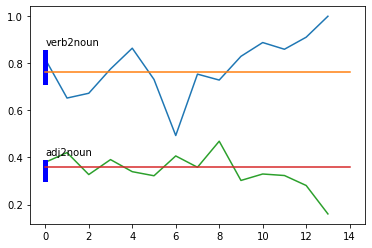

In [41]:
ya_verb2noun, ya_adj2noun = get_2nouns(book)

draw_verb_adj_plot([ya_verb2noun, ya_adj2noun], [verb2noun, adj2noun], ['verb2noun', 'adj2noun'])


In [42]:
book[600:610]

[TokenList<Он, вспомнил, халат, из, недавнего, наваждения, —, просвечивающий, зеленый, шелк, ,, который, очерчивает, ,, но, не, скрывает, ее, фигуру, ., metadata={text: "Он вспомнил халат из недавнего наваждения — просвечивающий зеленый шелк, который очерчивает, но не скрывает ее фигуру."}>, TokenList<Северус, снова, увидел, в, своем, воображении, ,, как, она, плавно, ,, слегка, покачивая, бедрами, ,, подходит, к, нему, ,, сидящему, в, кресле, ., metadata={text: "Северус снова увидел в своем воображении, как она плавно, слегка покачивая бедрами, подходит к нему, сидящему в кресле."}>, TokenList<Потом, упирается, маленькой, ножкой, на, сиденье, между, его, ногами, ,, наклоняется, и, начинает, медленно, расстегивать, пуговицы, на, его, сюртуке, ., metadata={text: "Потом упирается маленькой ножкой на сиденье между его ногами, наклоняется и начинает медленно расстегивать пуговицы на его сюртуке."}>, TokenList<Одну, за, другой, —, медленно, ,, невыносимо, медленно, ,, глядя, ему, прямо, в, 

Аналогично можно поступить только для синтаксически связанных пар слов.

In [43]:
def get_connections(book, main_pos, child_pos):
    cntr = 0
    overall = 0
    for sentence in book:
        overall += len(sentence)
        for word in sentence:
            if word['upos'] == child_pos:
                parent = word['head'] - 1
                if parent != -1 and sentence[parent]['upos'] == main_pos:
                    cntr += 1
    return cntr / overall

def get_connections_distr(book, main_pos, child_pos):
    dist = []
    phragment_len = 50
    for i in range(0, len(book), phragment_len):
        dist.append(get_connections(book[i: i+phragment_len], main_pos, child_pos))
    return dist


In [44]:
ya_verb_noun_overall = get_connections(book, 'VERB', 'NOUN')
ya_noun_adj_overall = get_connections(book, 'NOUN', 'ADJ')
ya_noun_noun_overall = get_connections(book, 'NOUN', 'NOUN')
ya_verb_noun_dist = get_connections_distr(book, 'VERB', 'NOUN')
ya_noun_adj_dist = get_connections_distr(book, 'NOUN', 'ADJ')
ya_noun_noun_dist = get_connections_distr(book, 'NOUN', 'NOUN')
ya_verb_noun_overall, ya_noun_adj_overall, ya_noun_noun_overall


(0.12395807543121234, 0.05240571098456714, 0.05438639927374763)

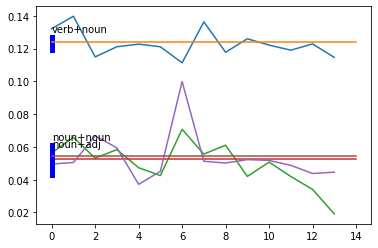

In [45]:
draw_verb_adj_plot([ya_verb_noun_dist, ya_noun_adj_dist, ya_noun_noun_dist], 
                   [ya_verb_noun_overall, ya_noun_adj_overall, ya_noun_noun_overall], 
                   ['verb+noun', 'noun+adj', 'noun+noun'], 0.003)